In [36]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import random
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,5)
plt.rcParams['savefig.dpi'] = 300
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('./LCDMA_October_2022/balanced_can_md.csv')
df = df.set_index(pd.DatetimeIndex(df['Date'])).iloc[200:,1:30]
df.describe().round(4).iloc[1:,:10]

,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,CON_new,RT_new
mean,0.0018,0.0019,0.0012,0.0021,0.0009,0.0002,0.0004,0.0015,0.0022,0.0024
std,0.0097,0.0106,0.0128,0.0092,0.0139,0.0144,0.0287,0.0198,0.0173,0.0235
min,-0.1133,-0.1257,-0.1460,-0.0996,-0.1384,-0.1388,-0.3189,-0.0888,-0.2094,-0.2178
25%,0.0001,-0.0003,-0.0029,0.0009,-0.0048,-0.0065,-0.0098,-0.0103,-0.0023,-0.0039
50%,0.0021,0.0024,0.0014,0.0024,0.0010,0.0006,0.0008,0.0020,0.0027,0.0026
75%,0.0043,0.0050,0.0070,0.0038,0.0084,0.0078,0.0122,0.0139,0.0070,0.0081
max,0.0551,0.0627,0.0648,0.0583,0.0434,0.0522,0.1852,0.0748,0.1374,0.1703


In [38]:
# Instantiate our model
model = sm.DynamicFactorMQ(endog=df, factors=2, factor_orders=1,
                           idiosyncratic_ar1=True)
# Fit the DFM
results = model.fit(maxiter=100, disp=True)

EM start iterations, llf=-8271.7
EM iteration 2, llf=-7810.5, convergence criterion=0.057364
EM iteration 3, llf=-7778.6, convergence criterion=0.0040935
EM iteration 4, llf=-7750.7, convergence criterion=0.0035823
EM iteration 5, llf=-7728, convergence criterion=0.0029335
EM iteration 6, llf=-7712.1, convergence criterion=0.002068
EM iteration 7, llf=-7702.4, convergence criterion=0.0012505
EM iteration 8, llf=-7697.3, convergence criterion=0.00066872
EM iteration 9, llf=-7694.7, convergence criterion=0.00034238
EM iteration 10, llf=-7693.2, convergence criterion=0.00018825
EM iteration 11, llf=-7692.3, convergence criterion=0.00012051
EM iteration 12, llf=-7691.6, convergence criterion=8.9742e-05
EM iteration 13, llf=-7691, convergence criterion=7.4913e-05
EM iteration 14, llf=-7690.5, convergence criterion=6.8373e-05
EM iteration 15, llf=-7690, convergence criterion=6.7395e-05
EM iteration 16, llf=-7689.4, convergence criterion=7.0678e-05
EM iteration 17, llf=-7688.8, convergence cr

In [39]:
dfm_pred = results.predict(start=100, end=199)
mse_gdp = mse(dfm_pred['GDP_new'], df['GDP_new'].iloc[100:200])
print(f'In-sample MSE of GDP: {round(mse_gdp,5)}')

In-sample MSE of GDP: 1e-05


In [40]:
num_oos=60
testset = df.iloc[-num_oos:]
h=1
dfm_forecast = pd.DataFrame()

# Refit w/o test set
model = sm.DynamicFactorMQ(endog=df.iloc[:-num_oos], factors=2, factor_orders=1,
                           idiosyncratic_ar1=True)
results = model.fit(maxiter=100, disp=False)

for i in range(-num_oos,0,h):

    results = results.apply(endog=df.iloc[:i])
    forecast = results.forecast(steps=h)
    dfm_forecast = pd.concat([dfm_forecast, forecast])

mse_gdp = mse(dfm_forecast['GDP_new'], testset['GDP_new'])
print(f'Pseudo-out-of-sample MSE of GDP: {round(mse_gdp,5)}')
    

Pseudo-out-of-sample MSE of GDP: 0.00039


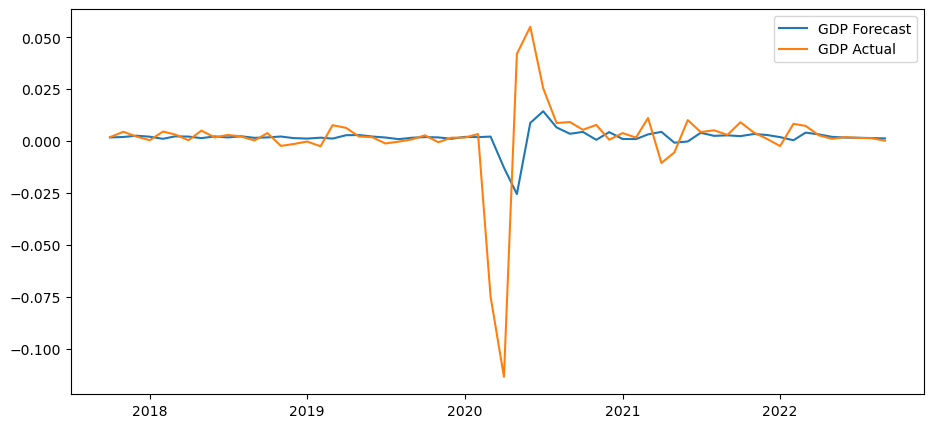

In [41]:
plt.plot(dfm_forecast['GDP_new'],  label='GDP Forecast')
plt.plot(testset['GDP_new'], label='GDP Actual')
plt.legend()
plt.show()

In [42]:
results = results.apply(df)
forecast = results.forecast(steps=h)
print('Out of sample forecast for next value of GDP:', round(forecast['GDP_new'].values[0],4))

Out of sample forecast for next value of GDP: 0.0034


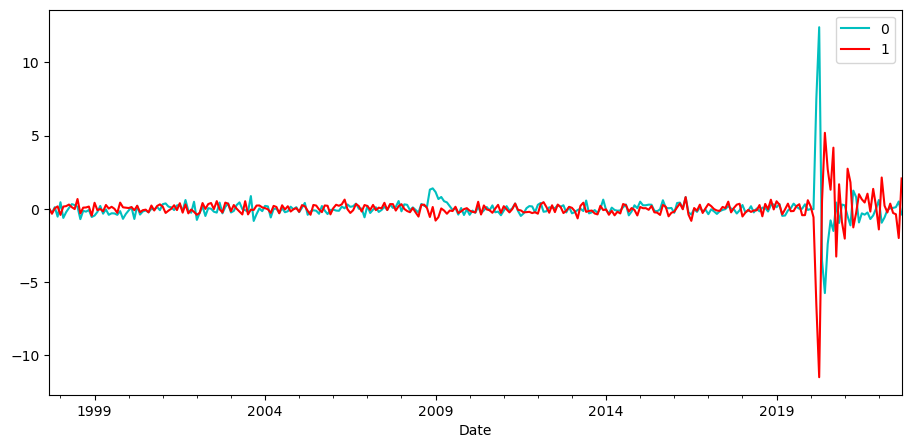

In [43]:
factor = results.factors.smoothed/results.factors.smoothed.std()
pd.DataFrame(factor, index=df.index).plot(color=['c','red'])
plt.show()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:      "GDP_new", and 28 more   No. Observations:                  301
Model:                Dynamic Factor Model   Log Likelihood              -33550.102
                   + 2 factors in 2 blocks   AIC                          67340.203
                     + AR(1) idiosyncratic   BIC                          67785.056
Date:                     Sat, 17 Dec 2022   HQIC                         67518.214
Time:                             10:46:43                                         
Sample:                         09-01-1997                                         
                              - 09-01-2022                                         
Covariance Type:              Not computed                                         
                            Observation equation:                             
==============================================================================
    Factor loadings:          0          1    idiosyncratic: AR(1)        var.
------------------------------------------------------------------------------
             GDP_new      -0.37      -0.08                   -0.23        0.03
             BSI_new      -0.36      -0.09                    0.35        0.01
             GPI_new      -0.34      -0.15                   -0.05        0.15
             SPI_new      -0.26       0.05                   -0.09        0.43
              IP_new      -0.33      -0.18                   -0.07        0.17
             NDM_new      -0.21      -0.13                   -0.25        0.60
              DM_new      -0.28      -0.06                   -0.11        0.43
            OILP_new      -0.20      -0.17                    0.00        0.63
             CON_new      -0.15       0.07                    0.07        0.84
              RT_new      -0.11       0.04                   -0.23        0.84
              WT_new      -0.23       0.02                   -0.21        0.58
              PA_new      -0.07       0.05                   -0.16        0.93
             FIN_new      -0.10      -0.00                   -0.05        0.91
         OIL_CAN_new      -0.07      -0.06                   -0.37        0.82
             EMP_CAN      -0.20       0.30                   -0.07        0.44
        EMP_SERV_CAN      -0.13       0.25                   -0.23        0.64
     EMP_FOR_OIL_CAN      -0.09       0.04                   -0.12        0.95
        EMP_CONS_CAN      -0.07       0.08                   -0.22        0.91
       EMP_SALES_CAN      -0.03       0.14                   -0.23        0.87
         EMP_FIN_CAN      -0.05       0.11                   -0.17        0.92
        EMP_MANU_CAN      -0.10       0.10                   -0.02        0.89
        EMP_PART_CAN       0.04       0.12                   -0.28        0.83
           UNEMP_CAN       0.19      -0.28                   -0.18        0.51
  UNEMP_DURA_1.4_CAN       0.09      -0.13                   -0.34        0.79
 UNEMP_DURA_5.13_CAN       0.09      -0.10                   -0.27        0.86
UNEMP_DURA_14.25_CAN       0.09      -0.11                   -0.29        0.84
  UNEMP_DURA_27._CAN       0.06      -0.13                   -0.28        0.85
UNEMP_DURAvg_CAN_new      -0.02      -0.00                   -0.49        0.76
          CLAIMS_CAN       0.12      -0.10                    0.66        0.51
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.20              6.58
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1      -0.05              3.47
=====================

<AxesSubplot: >

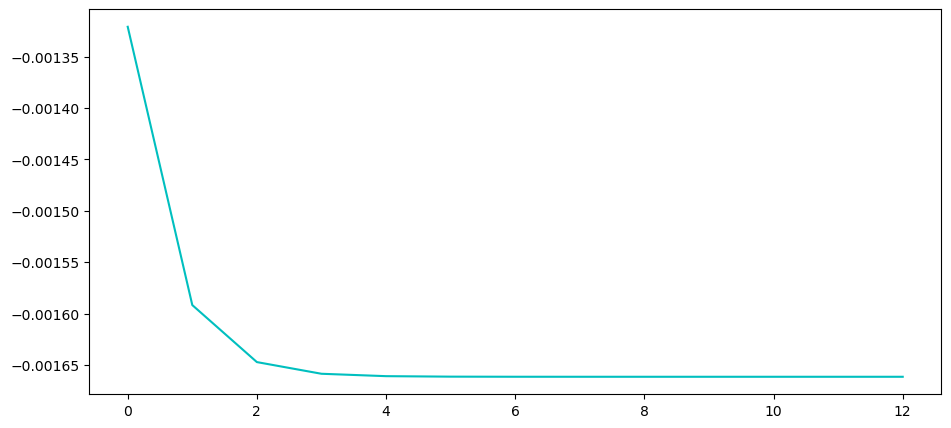

In [45]:
results.impulse_responses(12,0,cumulative=True)['GDP_new'].plot(color=['c'])